<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/StandingTime_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for standing time

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

In [ ]:
%%R
options(warn=-1)

## Data loading into dataframe

In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=StandingTimeMinutesPer2Hours/part-00000-tid-5876581890551720600-0e9afc0a-339b-4a8d-9159-2f92fdf60451-17582-34.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=StandingTimeMinutesPer2Hours/part-00000-tid-5876581890551720600-0e9afc0a-339b-4a8d-9159-2f92fdf60451-17582-34.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
   dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 32               544            2      9            Autumn        6    
2 38               2746           3+     8            Autumn        8    
3 159              544            2      5            Summer        14   
4 41               544            3+     2            Summer        22   
5 83               2746           1      5            Winter        2    
6 86               2746           3+     10           Winter        14   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [463,405 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1049 levels "1","2","3","4",..: 32 38 159 41 83 86 77 98 70 39 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 7 4 7 7 4 4 7 4 7 7 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 2 3 2 3 1 3 3 2 3 3 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 9 8 5 2 5 10 2 3 2 8 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 1 1 3 3 4 4 1 1 1 1 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 4 5 8 12 2 8 1 3 7 12 ...
 $ SensorValue     : num [1:463405] 47.9 54.6 23 91.6 67.9 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 1 2 1 1 2 2 1 2 1 1 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 463344


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  731
2 2                  710
3 3+                 733


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1049


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )

## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                         
Model1.0   12 4089048 4089180 -2044512  4089024 5906.3  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                        
Model1.1    5 4094206 4094261 -2047098  4094196 733.7  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                         
Model1.2   10 4094761 4094872 -2047371  4094741 188.47  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                         
Model1.3    6 4094751 4094817 -2047370  4094739 190.81  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.4: SensorValue ~ Hour + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                         
Model1.4   14 3956212 3956366 -1978092  3956184 138746 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 4094936 4094969 -2047465  4094930                         
Model1.5    4 4094886 4094930 -2047439  4094878 51.997  1  5.559e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
              npar     AIC    LRT   Pr(Chi)    
<none>             3947171                     
Parity           2 3947841    674 < 2.2e-16 ***
MonthsInMilk     9 3954866   7714 < 2.2e-16 ***
CalvingSeason    3 3947563    398 < 2.2e-16 ***
Hour            11 4088251 141102 < 2.2e-16 ***
MilkingType      1 3947216     47 6.507e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + HerdIdentifier + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + HerdIdentifier + 
Model2.1:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.1   53 3946199 3946785 -1973047  3946093 1019.1 24  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.2   38 3947017 3947437 -1973471  3946941 171.21  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.3:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.3   56 3946354 3946973 -1973121  3946242 870.28 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interactions with hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.4   51 3945186 3945749 -1972542  3945084 2028.7 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                        
Model2.5   40 3922327 3922769 -1961124  3922247 24865 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.6   62 3946346 3947031 -1973111  3946222 890.65 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType + 
                  MonthsInMilk*CalvingSeason + 
                  Hour*Parity + 
                  Hour*MilkingType + 
                  Hour*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * MilkingType + 
Model2.7:     MonthsInMilk * CalvingSeason + Hour * Parity + Hour * MilkingType + 
Model2.7:     Hour * CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   29 3947171 3947491 -1973556  3947113                         
Model2.7  149 3917936 3919582 -1958819  3917638 29475 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.7

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                 8293.163  9  < 2.2e-16 ***
Parity                        706.021  2  < 2.2e-16 ***
MilkingType                    46.079  1  1.136e-11 ***
CalvingSeason                 422.334  3  < 2.2e-16 ***
Hour                       175922.728 11  < 2.2e-16 ***
MonthsInMilk:Parity           924.407 18  < 2.2e-16 ***
MonthsInMilk:MilkingType      135.041  9  < 2.2e-16 ***
MonthsInMilk:CalvingSeason    949.463 27  < 2.2e-16 ***
Parity:Hour                  2081.153 22  < 2.2e-16 ***
MilkingType:Hour            25310.879 11  < 2.2e-16 ***
CalvingSeason:Hour            534.060 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hoursStandingtime.rdata")

# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 10             57.1 0.198 Inf      56.6      57.7  a       
 9              57.5 0.198 Inf      56.9      58.0  ab      
 8              57.5 0.198 Inf      56.9      58.1  ab      
 7              57.7 0.198 Inf      57.2      58.3   bc     
 6              58.1 0.198 Inf      57.5      58.7    c     
 5              58.7 0.198 Inf      58.2      59.3     d    
 4              60.1 0.198 Inf      59.5      60.6      e   
 3              61.4 0.198 Inf      60.9      62.0       f  
 2              62.5 0.198 Inf      62.0      63.1        g 
 1              63.4 0.198 Inf      62.9      64.0         h

Results are averaged over the levels of: Parity, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: tukey method for comparing a family of 10 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 1        58.5 0.186 Inf      58.0      58.9  a    
 2        59.2 0.185 Inf      58.8      59.7   b   
 3+       60.5 0.183 Inf      60.1      61.0    c  

Results are averaged over the levels of: MonthsInMilk, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean     SE  df asymp.LCL asymp.UCL .group       
 2     41.67 0.2019 Inf     41.09     42.25  a           
 0     47.19 0.2019 Inf     46.61     47.77   b          
 22    50.75 0.2019 Inf     50.17     51.33    c         
 4     55.69 0.2019 Inf     55.12     56.27     d        
 20    56.60 0.2019 Inf     56.02     57.18      e       
 10    58.30 0.2019 Inf     57.72     58.87       f      
 8     60.28 0.2019 Inf     59.71     60.86        g     
 12    61.54 0.2019 Inf     60.97     62.12         h    
 6     62.55 0.2019 Inf     61.97     63.12          i   
 14    69.07 0.2019 Inf     68.49     69.65           j  
 18    69.70 0.2019 Inf     69.12     70.28            k 
 16    79.63 0.2019 Inf     79.06     80.21             l

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Summer          58.4 0.190 Inf      57.9      58.9  a    
 Autumn          58.9 0.190 Inf      58.4      59.4   b   
 Spring          59.8 0.193 Inf      59.3      60.3    c  
 Winter          60.6 0.193 Inf      60.1      61.1     d 

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions

### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 2      38.6 0.248 Inf      37.9      39.3  a          
 0      44.4 0.248 Inf      43.7      45.2   b         
 22     48.8 0.248 Inf      48.1      49.5    c        
 4      55.2 0.248 Inf      54.5      55.9     d       
 20     56.0 0.248 Inf      55.3      56.8      e      
 10     58.0 0.248 Inf      57.2      58.7       f     
 8      60.7 0.248 Inf      60.0      61.4        g    
 12     61.0 0.248 Inf      60.3      61.7        g    
 6      62.7 0.248 Inf      61.9      63.4         h   
 14     68.5 0.248 Inf      67.8      69.2          i  
 18     69.1 0.248 Inf      68.4      69.8          i  
 16     78.6 0.248 Inf      77.9      79.4           j 

Parity = 2:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 2      40.7 0.247 Inf      40.0      41.4  a          
 0      46.7 0.247 Inf      46.0      47.4   b         
 22     50.1 0.247 Inf      49.4      50.8    c        
 4      54.3 0.247 Inf 

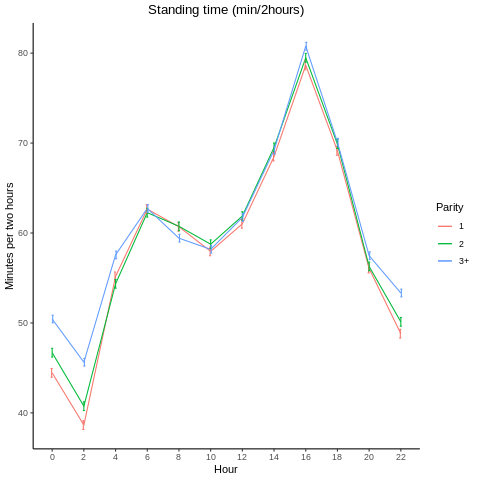

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 2      40.4 0.334 Inf      39.4      41.3  a          
 4      44.5 0.334 Inf      43.5      45.4   b         
 0      47.7 0.334 Inf      46.7      48.6    c        
 22     51.4 0.334 Inf      50.4      52.3     d       
 10     58.3 0.334 Inf      57.3      59.2      e      
 6      58.8 0.334 Inf      57.9      59.8      e      
 20     59.7 0.334 Inf      58.8      60.7       f     
 12     61.0 0.334 Inf      60.0      61.9        g    
 8      64.3 0.334 Inf      63.3      65.2         h   
 14     65.8 0.334 Inf      64.8      66.7          i  
 18     73.3 0.334 Inf      72.4      74.3           j 
 16     73.4 0.334 Inf      72.4      74.4           j 

MilkingType = CMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 2      43.0 0.223 Inf      42.4      43.6  a          
 0      46.7 0.223 Inf      46.1      47.4   b         
 22     50.1 0.223 Inf      49.5      50.8    c        
 20     5

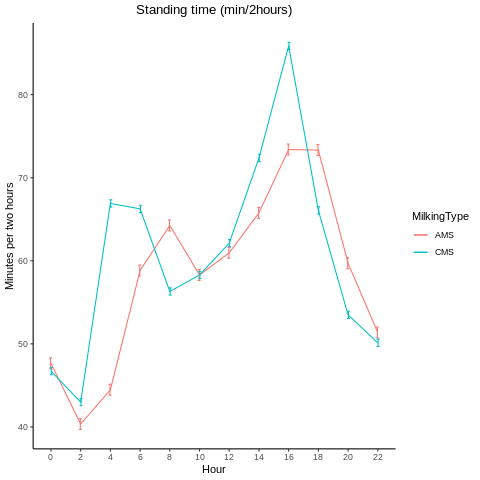

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 463405' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 463405' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 463405)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 2      41.0 0.248 Inf      40.3      41.8  a           
 0      46.6 0.248 Inf      45.9      47.3   b          
 22     50.1 0.248 Inf      49.4      50.8    c         
 4      54.5 0.248 Inf      53.8      55.2     d        
 20     56.1 0.248 Inf      55.4      56.8      e       
 10     58.8 0.248 Inf      58.1      59.5       f      
 8      60.3 0.248 Inf      59.6      61.0        g     
 12     61.1 0.248 Inf      60.4      61.8         h    
 6      62.2 0.248 Inf      61.5      62.9          i   
 14     67.5 0.248 Inf      66.8      68.2           j  
 18     69.2 0.248 Inf      68.5      69.9            k 
 16     79.2 0.248 Inf      78.5      79.9             l

CalvingSeason = Spring:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 2      42.4 0.261 Inf      41.6      43.1  a           
 0      47.9 0.261 Inf      47.2      48.7   b          
 22     51.3 0.261 Inf      50.6      5

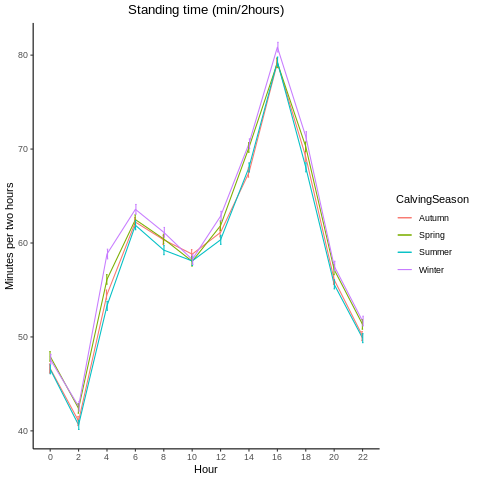

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))